# Final Project - Zhengyang Kris Weng Submission 12/10/2024

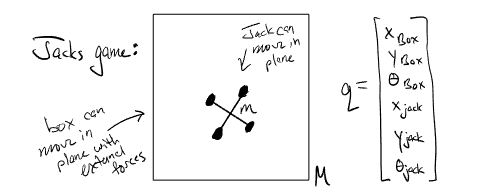

two bodies, six degrees of freedom, includes impacts, has external forces (for shaking the cup),
and is planar

## 1. 
This is the default final project for ME314

## 2. 
I set up the frames in the box and in the jack such that the walls of the box each has a frame attached to it, and the points on the jack each also has a frame attached to it.

The frames are simply translated to the corresponding position by offsetting the length of the side of the box `L_box` (to avoid conflict with `L`), or the length fo the jack `l`

![frame_setup](Screenshot%20from%202024-12-11%2018-35-16.png)


## 3.
I found EL equation by first finding the lagrangian of the whole system. KE was computed with rigid body motion formula - where I found the inertia matrices of the jacks and box and multiplying them with the spatial velocity 6-vector left and right.

PE is much easier to find in comparison - it's simply the m*g*y position of COM for each respectively.

Summing KE and PE finds us the lagrangian. Taking derivative w.r.t state variables and their time derivatives finds us the LHS of the E-L equation.

Right hand side of the E-L equation has the force input for this system. I used a +y force on the box to keep in space (in addition, I set the mass of the box to be much larger than the jack to minimize effect from Newton's third law). I've also added a force to spin the box.

Setting these to the LHS and RHS gives us the E-L equation for this system.

## 4.
Code works! Please see the animation attached and the plots for state variable trajectories. The jack initially falls under gravity, and bounces off the walls of the box once it comes in contact.

In [1]:
import sympy as sym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from tqdm import tqdm

In [2]:
def TransToRp(T):
    """Converts a homogeneous transformation matrix into a rotation matrix
    and position vector

    :param T: A homogeneous transformation matrix
    :return R: The corresponding rotation matrix,
    :return p: The corresponding position vector.

    Example Input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        (np.array([[1, 0,  0],
                   [0, 0, -1],
                   [0, 1,  0]]),
         np.array([0, 0, 3]))
    """
    R = T[:3, :3]
    p = T[:3, 3]
    return R, p


def TransInv(T):
    """Inverts a homogeneous transformation matrix

    :param T: A homogeneous transformation matrix
    :return: The inverse of T
    Uses the structure of transformation matrices to avoid taking a matrix
    inverse, for efficiency.

    Example input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        np.array([[1,  0, 0,  0],
                  [0,  0, 1, -3],
                  [0, -1, 0,  0],
                  [0,  0, 0,  1]])
    """
    R, p = TransToRp(T)
    Rt = R.T
    return sym.Matrix.vstack(sym.Matrix.hstack(Rt, -Rt * p), sym.Matrix([[0, 0, 0, 1]]))
    
def se3ToVec(se3mat):
    """ Converts an se3 matrix into a spatial velocity vector

    :param se3mat: A 4x4 matrix in se3
    :return: The spatial velocity 6-vector corresponding to se3mat

    Example Input:
        se3mat = np.array([[ 0, -3,  2, 4],
                           [ 3,  0, -1, 5],
                           [-2,  1,  0, 6],
                           [ 0,  0,  0, 0]])
    Output:
        np.array([1, 2, 3, 4, 5, 6])
    """
    return sym.Matrix([se3mat[2, 1], se3mat[0, 2], se3mat[1, 0], se3mat[0, 3], se3mat[1, 3], se3mat[2, 3]])

def get_se3(x, y, theta):
    """
    This function return SE(3) given x, y, theta
    """
    return np.array([[np.cos(theta), -np.sin(theta), 0, x],
                     [np.sin(theta),  np.cos(theta), 0, y],
                     [            0,              0, 1, 0],
                     [            0,              0, 0, 1]])

In [3]:
# Declare variables
t, m, M, g, l, L_box = sym.symbols('t m M g l L') # L bugged lagrange again =/
x_box = sym.Function('x_box')(t)
y_box = sym.Function('y_box')(t)
theta_box = sym.Function('theta_box')(t)
x_jack = sym.Function('x_jack')(t)
y_jack = sym.Function('y_jack')(t)
theta_jack = sym.Function('theta_jack')(t)

q = sym.Matrix([x_box, y_box, theta_box, x_jack, y_jack, theta_jack])
qdot = q.diff(t)
qddot = qdot.diff(t)

In [4]:
# Transformations

# world to box
g_w_b = sym.Matrix([[sym.cos(theta_box), -sym.sin(theta_box), 0, x_box], [sym.sin(theta_box), sym.cos(theta_box), 0, y_box], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b1 = sym.Matrix([[1, 0, 0, L_box], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b2 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, -L_box], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b3 = sym.Matrix([[1, 0, 0, -L_box], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_b_b4 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, L_box], [0, 0, 1, 0], [0, 0, 0, 1]])

# world to jack
g_w_j = sym.Matrix([[sym.cos(theta_jack), -sym.sin(theta_jack), 0, x_jack], [sym.sin(theta_jack), sym.cos(theta_jack), 0, y_jack], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j1 = sym.Matrix([[1, 0, 0, l], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j2 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, -l], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j3 = sym.Matrix([[1, 0, 0, -l], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
g_j_j4 = sym.Matrix([[1, 0, 0, 0], [0, 1, 0, l], [0, 0, 1, 0], [0, 0, 0, 1]])

# world to box sides
g_w_b1 = g_w_b * g_b_b1
g_w_b2 = g_w_b * g_b_b2
g_w_b3 = g_w_b * g_b_b3
g_w_b4 = g_w_b * g_b_b4

# world to jack ends
g_w_j1 = g_w_j * g_j_j1
g_w_j2 = g_w_j * g_j_j2
g_w_j3 = g_w_j * g_j_j3
g_w_j4 = g_w_j * g_j_j4

In [5]:
# impact relations
g_w_b_list = [g_w_b1, g_w_b2, g_w_b3, g_w_b4]
g_w_j_list = [g_w_j1, g_w_j2, g_w_j3, g_w_j4]

g_b_j = [[TransInv(g_w_b) * g_w_j for g_w_j in g_w_j_list] for g_w_b in g_w_b_list]
# display(g_b_j)

# Velocity
v_box = se3ToVec(np.array(TransInv(g_w_b) * g_w_b.diff(t)))
v_jack = se3ToVec(np.array(TransInv(g_w_j) * g_w_j.diff(t)))

j_jack = 4*(m/4)*l**2
j_box = 4*(M/4)*L_box**2
# display(j_box)

I_box = sym.Matrix([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, j_box, 0, 0, 0],
                    [0, 0, 0, M, 0, 0],
                    [0, 0, 0, 0, M, 0],
                    [0, 0, 0, 0, 0, M]])
I_jack = sym.Matrix([[0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0],
                    [0, 0, j_jack, 0, 0, 0],
                    [0, 0, 0, m, 0, 0],
                    [0, 0, 0, 0, m, 0],
                    [0, 0, 0, 0, 0, m]])

# Kinetic energy
T_box = 0.5 * v_box.dot(I_box * v_box)
T_jack = 0.5 * v_jack.dot(I_jack * v_jack)

KE = T_box + T_jack

# Potential Energy
PE = m*g*y_jack + M*g*y_box

# Calculate the Lagrangian:
L = KE.simplify() - PE.simplify()
print("EL Equation:")
display(L)


EL Equation:


0.5*L**2*M*Derivative(theta_box(t), t)**2 + 0.5*M*Derivative(x_box(t), t)**2 + 0.5*M*Derivative(y_box(t), t)**2 - g*(M*y_box(t) + m*y_jack(t)) + 0.5*l**2*m*Derivative(theta_jack(t), t)**2 + 0.5*m*Derivative(x_jack(t), t)**2 + 0.5*m*Derivative(y_jack(t), t)**2

In [6]:
# EL equations
dLdq = sym.Matrix([L]).jacobian(q).T
dLdqdot = sym.Matrix([L]).jacobian(qdot).T
dLdqdotdt = dLdqdot.diff(t)

# Let there be force
f_y_box = 1*M*g
f_theta_box = 50000*sym.sin(sym.pi*t)
F = sym.Matrix([0, f_y_box, f_theta_box, 0, 0, 0])

EL_lhs = dLdqdotdt - dLdq
EL_rhs = F
EL_lhs.simplify()
EL_rhs.simplify()
EL_eqn = sym.Eq(EL_lhs, EL_rhs)
display(EL_eqn)

EL_subbed = EL_eqn.subs({M: 1000, m: 1, l: 0.5, L_box: 5, g: 9.81})

# Solve
soln = sym.solve(EL_subbed, qddot, dict=True)
for sol in soln:
    print('\n\033[1mSymbolic Solution: ')
    for v in qddot:
        display(sym.Eq(v, sol[v].simplify()))

Eq(Matrix([
[          1.0*M*Derivative(x_box(t), (t, 2))],
[    M*(g + 1.0*Derivative(y_box(t), (t, 2)))],
[ 1.0*L**2*M*Derivative(theta_box(t), (t, 2))],
[         1.0*m*Derivative(x_jack(t), (t, 2))],
[   m*(g + 1.0*Derivative(y_jack(t), (t, 2)))],
[1.0*l**2*m*Derivative(theta_jack(t), (t, 2))]]), Matrix([
[              0],
[            M*g],
[50000*sin(pi*t)],
[              0],
[              0],
[              0]]))


Symbolic Solution: 


Eq(Derivative(x_box(t), (t, 2)), 0.0)

Eq(Derivative(y_box(t), (t, 2)), 0.0)

Eq(Derivative(theta_box(t), (t, 2)), 2.0*sin(3.14159265358979*t))

Eq(Derivative(x_jack(t), (t, 2)), 0.0)

Eq(Derivative(y_jack(t), (t, 2)), -9.81)

Eq(Derivative(theta_jack(t), (t, 2)), 0.0)

In [7]:
# Lambdify
x_box_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[0]])
y_box_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[1]])
theta_box_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[2]])
x_jack_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[3]])
y_jack_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[4]])
theta_jack_ddot_func = sym.lambdify([q[0], q[1], q[2], q[3], q[4], q[5], qdot[0], qdot[1], qdot[2], qdot[3], qdot[4], qdot[5], t], soln[0][qddot[5]])

def dynamics(s, t):
    sdot = np.array([
        s[6],
        s[7],
        s[8],
        s[9],
        s[10],
        s[11],
        x_box_ddot_func(*s, t),
        y_box_ddot_func(*s, t),
        theta_box_ddot_func(*s, t),
        x_jack_ddot_func(*s, t),
        y_jack_ddot_func(*s, t),
        theta_jack_ddot_func(*s, t)
    ])
    return sdot

In [8]:
# Define acceleration matrix:
qddot_Matrix = sym.Matrix([qdot[0], soln[0][qddot[0]],
                       qdot[1], soln[0][qddot[1]],
                       qdot[2], soln[0][qddot[2]],
                       qdot[3], soln[0][qddot[3]],
                       qdot[4], soln[0][qddot[4]],
                       qdot[5], soln[0][qddot[5]]])

# Define dummy symbols:
x_b_l, y_b_l, theta_b_l, x_j_l, y_j_l, theta_j_l, x_b_ldot, y_b_ldot, theta_b_ldot, x_j_ldot, y_j_ldot, theta_j_ldot = sym.symbols('x_box_l, y_box_l, theta_box_l, x_jack_l, y_jack_l, theta_jack_l, x_box_ldot, y_box_ldot, theta_box_ldot, x_jack_ldot, y_jack_ldot, theta_jack_ldot')

static_dict = {q[0]:x_b_l, q[1]:y_b_l, q[2]:theta_b_l,
              q[3]:x_j_l, q[4]:y_j_l, q[5]:theta_j_l,
              qdot[0]:x_b_ldot, qdot[1]:y_b_ldot, qdot[2]:theta_b_ldot,
              qdot[3]:x_j_ldot, qdot[4]:y_j_ldot, qdot[5]:theta_j_ldot,
              M:1000, m:1, l:0.5, L_box:5, g:9.81}
qddot_d = qddot_Matrix.subs(static_dict)
qddot_lambdify = sym.lambdify([x_b_l, x_b_ldot ,y_b_l, y_b_ldot, theta_b_l, theta_b_ldot,
                           x_j_l, x_j_ldot ,y_j_l, y_j_ldot, theta_j_l, theta_j_ldot, t], qddot_d)

In [9]:
r_jack_hat = sym.Matrix([x_jack, y_jack, theta_jack, 1])

# Define impact constraints
phi_b_j = []
indices = [3, 7, 3, 7]  # Indices for each wall

for i in range(4):
    phi_b_j.append([(g_b_j[i][j][indices[i % 2]]).subs(static_dict) for j in range(4)])

# Accessing the constraints for each wall
phi_b1_j = phi_b_j[0]
phi_b2_j = phi_b_j[1]
phi_b3_j = phi_b_j[2]
phi_b4_j = phi_b_j[3]

# Define impact constraint
phi_subbed = sym.Matrix([phi for sublist in phi_b_j for phi in sublist])
phi_subbed.simplify()

In [10]:
# Compute the Hamiltonian:
H = (dLdqdot.T * qdot)[0] - L

# Compute expressions:
H_subbed = H.subs(static_dict)
dLdqdot_subbed = dLdqdot.subs(static_dict)
dphidq_subbed = phi_subbed.jacobian([x_b_l, y_b_l, theta_b_l, x_j_l, y_j_l, theta_j_l])

# Define dummy symbols for tau+:
lamb = sym.symbols(r'/lambda')
x_b_dot_Plus, y_b_dot_Plus, theta_b_dot_Plus, x_j_dot_Plus, y_j_dot_Plus, theta_j_dot_Plus = sym.symbols(r'x_box_dot_+, y_box_dot_+, theta_box_dot_+, x_jack_dot_+, y_jack_dot_+, theta_jack_dot_+')

impact_dict = {x_b_ldot:x_b_dot_Plus, y_b_ldot:y_b_dot_Plus, theta_b_ldot:theta_b_dot_Plus,
               x_j_ldot:x_j_dot_Plus, y_j_ldot:y_j_dot_Plus, theta_j_ldot:theta_j_dot_Plus}

# Evaluate expressions at tau+:
dLdqdot_subbed_post = dLdqdot_subbed.subs(impact_dict)
dphidq_subbed_post = dphidq_subbed.subs(impact_dict)
H_subbed_post = H_subbed.subs(impact_dict)

In [11]:
impact_eqns_list = []

# Define equations
lhs = sym.Matrix([dLdqdot_subbed_post[0] - dLdqdot_subbed[0],
              dLdqdot_subbed_post[1] - dLdqdot_subbed[1],
              dLdqdot_subbed_post[2] - dLdqdot_subbed[2],
              dLdqdot_subbed_post[3] - dLdqdot_subbed[3],
              dLdqdot_subbed_post[4] - dLdqdot_subbed[4],
              dLdqdot_subbed_post[5] - dLdqdot_subbed[5],
              H_subbed_post - H_subbed])

for i in range(phi_subbed.shape[0]):
    rhs = sym.Matrix([lamb*dphidq_subbed[i,0],
                  lamb*dphidq_subbed[i,1],
                  lamb*dphidq_subbed[i,2],
                  lamb*dphidq_subbed[i,3],
                  lamb*dphidq_subbed[i,4],
                  lamb*dphidq_subbed[i,5],
                  0])
    impact_eqns_list.append(sym.Eq(lhs, rhs))

In [12]:
post_list = [x_b_dot_Plus, y_b_dot_Plus, theta_b_dot_Plus,
            x_j_dot_Plus, y_j_dot_Plus, theta_j_dot_Plus]

def impact_update(s, impact_eqns, dum_list):
    """ This function updates the system after impact.
    It returns the updated s array after impact.
    
    Parameters:
    s: current state
    impact_eqns: impact equations to solve
    dum_list: list of dummy variables for post-impact velocities
    
    Returns:
    numpy array: updated state after impact, or original state if no valid solution found
    """
    subs_dict = {x_b_l:s[0], y_b_l:s[1], theta_b_l:s[2],
                 x_j_l:s[3], y_j_l:s[4], theta_j_l:s[5],
                 x_b_ldot:s[6], y_b_ldot:s[7], theta_b_ldot:s[8],
                 x_j_ldot:s[9], y_j_ldot:s[10], theta_j_ldot:s[11]}
    
    try:
        new_impact_eqns = impact_eqns.subs(subs_dict)
        impact_solns = sym.solve(new_impact_eqns, [x_b_dot_Plus, y_b_dot_Plus, theta_b_dot_Plus,
                                               x_j_dot_Plus, y_j_dot_Plus, theta_j_dot_Plus,
                                               lamb], dict=True)
        
        if not impact_solns:  # If no solutions found
            print("No solutions found for impact equations")
            return s  # Return original state
            
        if len(impact_solns) == 1:
            print("Single solution found - using it")
            sol = impact_solns[0]
        else:
            # Find the first solution with non-zero lambda
            valid_sol = None
            for sol in impact_solns:
                lamb_sol = sol[lamb]
                if abs(lamb_sol) >= 1e-06:
                    valid_sol = sol
                    break
            
            if valid_sol is None:
                print("No valid solutions with non-zero lambda found")
                return s  # Return original state
            sol = valid_sol

        # Create updated state array
        return np.array([
            s[0],  # q will be the same after impact
            s[1],
            s[2],
            s[3],
            s[4],
            s[5],
            float(sym.N(sol[dum_list[0]], 15)),  # q_dot will change after impact
            float(sym.N(sol[dum_list[1]], 15)),
            float(sym.N(sol[dum_list[2]], 15)),
            float(sym.N(sol[dum_list[3]], 15)),
            float(sym.N(sol[dum_list[4]], 15)),
            float(sym.N(sol[dum_list[5]], 15)),
        ])
        
    except Exception as e:
        print(f"Error in impact_update: {str(e)}")
        return s  # Return original state if anything goes wrong

In [13]:
phi_func = sym.lambdify([x_b_l, y_b_l, theta_b_l,
                     x_j_l, y_j_l, theta_j_l,
                     x_b_ldot, y_b_ldot, theta_b_ldot,
                     x_j_ldot, y_j_ldot, theta_j_ldot],
                    phi_subbed)

def impact_condition(s, phi_func, threshold=1e-1):
    """ This function checks the system for impact.
    
    Parameters:
    s: current state array
    phi_func: function that computes constraint values
    threshold: threshold for detecting impact
    
    Returns:
    tuple: (bool indicating impact, index of impacting constraint or None)
    """
    try:
        phi_val = phi_func(*s)
        
        # Convert symbolic results to float values
        phi_numerical = np.array([float(sym.N(val)) if hasattr(val, 'free_symbols') else float(val) 
                                for val in phi_val])
        
        # Check each constraint
        for i in range(len(phi_numerical)):
            if (phi_val[i] > -threshold) and (phi_val[i] < threshold):
                return (True, i)
        return (False, None)
        
    except Exception as e:
        print(f"Error in impact_condition: {str(e)}")
        return (False, None)  # Return no impact in case of error

In [14]:
def integrate(f, xt, dt, time):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.
    
    Parameters
    ============
    dyn: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        current step x(t)
    dt: 
        step size for integration
    time:
        step time
        
    Return
    ============
    new_x: 
        value of x(t+dt) integrated from x(t)
    """
    k1 = dt * f(xt, time)
    k2 = dt * f(xt+k1/2., time)
    k3 = dt * f(xt+k2/2., time)
    k4 = dt * f(xt+k3, time)
    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)

    return new_xt


def simulate_impact(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan), N)
    xtraj = np.zeros((len(x0), N))
    time = 0
    for i in tqdm(range(N)):
        time = time + dt
        (impact, impact_num) = impact_condition(x, phi_func, 1e-1)
        if impact is True:
            x = impact_update(x, impact_eqns_list[impact_num], post_list)
            xtraj[:, i]=integrate(f, x, dt, time)
        else:
            xtraj[:, i]=integrate(f, x, dt, time)
        x = np.copy(xtraj[:,i]) 
    return xtraj

<>:2: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\d'

<>:2: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\d'

/tmp/ipykernel_18539/3197480517.py:2: SyntaxWarning:

invalid escape sequence '\d'

/tmp/ipykernel_18539/3197480517.py:35: SyntaxWarning:

invalid escape sequence '\d'



In [15]:
# Simulate the motion:
tspan = [0, 10]
dt = 0.01
# s = [x_box, y_box, theta_box, x_jack, y_jack, theta_jack, x_box_dot, y_box_dot, theta_box_dot, x_jack_dot, y_jack_dot, theta_jack_dot]
s0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -1.57, 0, 0, 0])

N = int((max(tspan) - min(tspan))/dt)
tvec = np.linspace(min(tspan), max(tspan), N)
traj = simulate_impact(dynamics, s0, tspan, dt, integrate)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_18539/4294557351.py:22: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 1000/1000 [00:08<00:00, 119.47it/s]


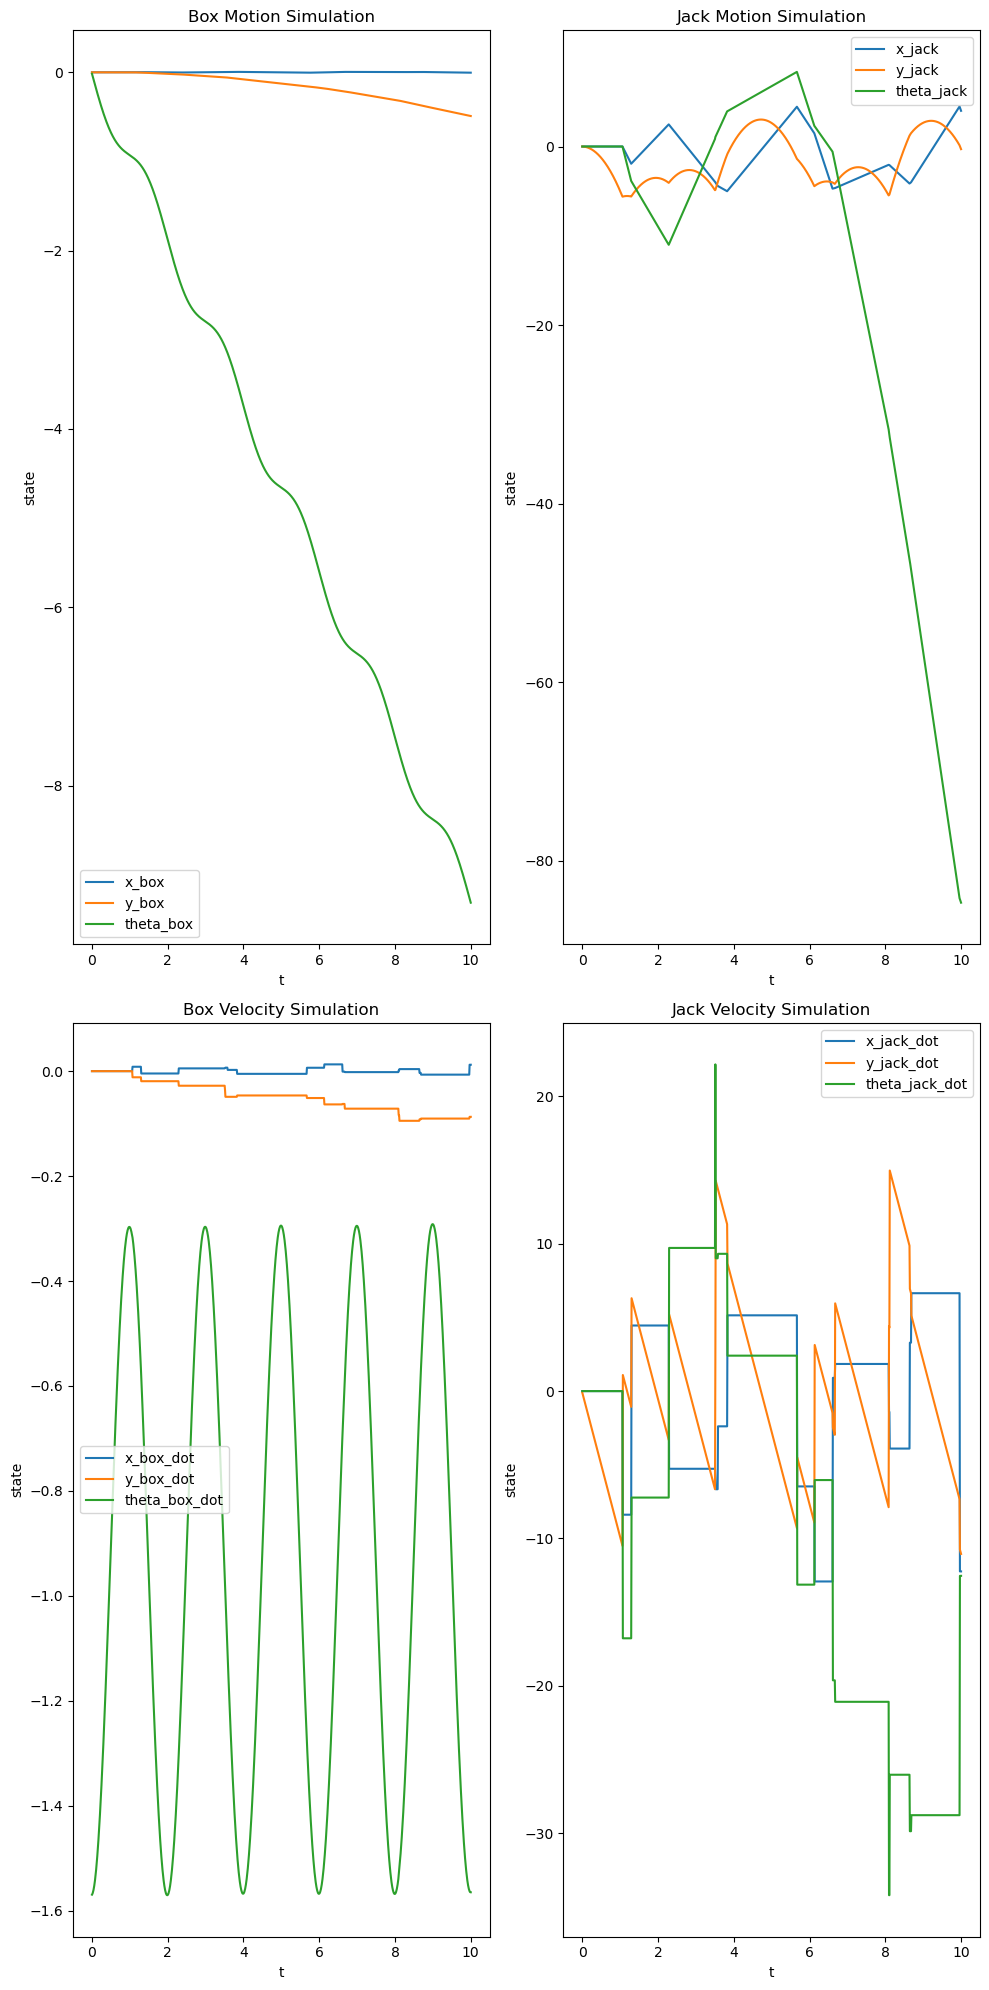

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 20))

# Box Motion Simulation
axs[0, 0].plot(tvec, traj[0], label='x_box')
axs[0, 0].plot(tvec, traj[1], label='y_box')
axs[0, 0].plot(tvec, traj[2], label='theta_box')
axs[0, 0].set_title('Box Motion Simulation')
axs[0, 0].set_xlabel('t')
axs[0, 0].set_ylabel('state')
axs[0, 0].legend()

# Jack Motion Simulation
axs[0, 1].plot(tvec, traj[3], label='x_jack')
axs[0, 1].plot(tvec, traj[4], label='y_jack')
axs[0, 1].plot(tvec, traj[5], label='theta_jack')
axs[0, 1].set_title('Jack Motion Simulation')
axs[0, 1].set_xlabel('t')
axs[0, 1].set_ylabel('state')
axs[0, 1].legend()

# Box Velocity Simulation
axs[1, 0].plot(tvec, traj[6], label='x_box_dot')
axs[1, 0].plot(tvec, traj[7], label='y_box_dot')
axs[1, 0].plot(tvec, traj[8], label='theta_box_dot')
axs[1, 0].set_title('Box Velocity Simulation')
axs[1, 0].set_xlabel('t')
axs[1, 0].set_ylabel('state')
axs[1, 0].legend()

# Jack Velocity Simulation
axs[1, 1].plot(tvec, traj[9], label='x_jack_dot')
axs[1, 1].plot(tvec, traj[10], label='y_jack_dot')
axs[1, 1].plot(tvec, traj[11], label='theta_jack_dot')
axs[1, 1].set_title('Jack Velocity Simulation')
axs[1, 1].set_xlabel('t')
axs[1, 1].set_ylabel('state')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
def animate_jack_in_a_box(config_array,l=1,w=0.2,T=10):
    """
    Function to generate web-based animation of the system

    Parameters:
    ================================================
    config_array:
        trajectory of theta1 and theta2, should be a NumPy array with
        shape of (2,N)
    L1:
        length of the first pendulum
    L2:
        length of the second pendulum
    T:
        length/seconds of animation duration

    Returns: None
    """
    ################################
    # Imports required for animation. (leave this part)
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration. (leave this part)
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    
    ###############################################
    # Getting data from pendulum angle trajectories.
    N = len(config_array[0])
    
    x_box_array = config_array[0]
    y_box_array = config_array[1]
    theta_box_array = config_array[2]
    x_jack_array = config_array[3]
    y_jack_array = config_array[4]
    theta_jack_array = config_array[5]

    b1_x_array = np.zeros(N, dtype=np.float32)
    b1_y_array = np.zeros(N, dtype=np.float32)
    b2_x_array = np.zeros(N, dtype=np.float32)
    b2_y_array = np.zeros(N, dtype=np.float32)
    b3_x_array = np.zeros(N, dtype=np.float32)
    b3_y_array = np.zeros(N, dtype=np.float32)
    b4_x_array = np.zeros(N, dtype=np.float32)
    b4_y_array = np.zeros(N, dtype=np.float32)
    
    j_x_array = np.zeros(N, dtype=np.float32)
    j_y_array = np.zeros(N, dtype=np.float32)
    j1_x_array = np.zeros(N, dtype=np.float32)
    j1_y_array = np.zeros(N, dtype=np.float32)
    j2_x_array = np.zeros(N, dtype=np.float32)
    j2_y_array = np.zeros(N, dtype=np.float32)
    j3_x_array = np.zeros(N, dtype=np.float32)
    j3_y_array = np.zeros(N, dtype=np.float32)
    j4_x_array = np.zeros(N, dtype=np.float32)
    j4_y_array = np.zeros(N, dtype=np.float32)
    
    for t in range(N):
        g_w_b = get_se3(x_box_array[t], y_box_array[t], theta_box_array[t])
        g_w_j = get_se3(x_jack_array[t], y_jack_array[t], theta_jack_array[t])

        b1 = g_w_b.dot(np.array([5, 5, 0, 1]))
        b1_x_array[t] = b1[0]
        b1_y_array[t] = b1[1]
        b2 = g_w_b.dot(np.array([5, -5, 0, 1]))
        b2_x_array[t] = b2[0]
        b2_y_array[t] = b2[1]
        b3 = g_w_b.dot(np.array([-5, -5, 0, 1]))
        b3_x_array[t] = b3[0]
        b3_y_array[t] = b3[1]
        b4 = g_w_b.dot(np.array([-5, 5, 0, 1]))
        b4_x_array[t] = b4[0]
        b4_y_array[t] = b4[1]    
        
        j = g_w_j.dot(np.array([0, 0, 0, 1]))
        j_x_array[t] = j[0]
        j_y_array[t] = j[1]
        j1 = g_w_j.dot(np.array([0.5, 0, 0, 1]))
        j1_x_array[t] = j1[0]
        j1_y_array[t] = j1[1]
        j2 = g_w_j.dot(np.array([0, -0.5, 0, 1]))
        j2_x_array[t] = j2[0]
        j2_y_array[t] = j2[1]
        j3 = g_w_j.dot(np.array([-0.5, 0, 0, 1]))
        j3_x_array[t] = j3[0]
        j3_y_array[t] = j3[1]
        j4 = g_w_j.dot(np.array([0, 0.5, 0, 1]))
        j4_x_array[t] = j4[0]
        j4_y_array[t] = j4[1]    
    
    ####################################
    # Axis limits.
    xm = -10
    xM = 10
    ym = -12
    yM = 12

    ###########################
    # Defining data dictionary.
    data=[dict(name = 'Box'),
          dict(name = 'Jack'),
          dict(name = 'Jack_Masses'),
        ]
    
    ################################
    # Preparing simulation layout.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Jack in a Box Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    frames=[dict(data=[
            dict(x=[b1_x_array[k],b2_x_array[k],b3_x_array[k],b4_x_array[k],b1_x_array[k]], 
                 y=[b1_y_array[k],b2_y_array[k],b3_y_array[k],b4_y_array[k],b1_y_array[k]], 
                 mode='lines',
                 line=dict(color='black', width=3)
                 ),
            dict(x=[j1_x_array[k],j3_x_array[k],j_x_array[k],j2_x_array[k],j4_x_array[k]],
                 y=[j1_y_array[k],j3_y_array[k],j_y_array[k],j2_y_array[k],j4_y_array[k]],
                 mode='lines',
                 line=dict(color='blue', width=3)
                 ),
            go.Scatter(
                x=[j1_x_array[k],j2_x_array[k],j3_x_array[k],j4_x_array[k]],
                y=[j1_y_array[k],j2_y_array[k],j3_y_array[k],j4_y_array[k]],
                mode="markers",
                marker=dict(color='red', size=6)),
                 ]) for k in range(N)]
    
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

##############
# The animation:
animate_jack_in_a_box(traj)